In [ ]:
from fastai.vision.all import *
import re
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import torch
from fastai.callback.tracker import EarlyStoppingCallback

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Mon Aug 25 19:53:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# path = Path('./data/pneumothorax/png_images')
path = Path('/content/drive/MyDrive/VIU/TFM/data/pneumothorax/png_images')

# Filtramos solo los archivos de entrenamiento
files = [f for f in path.ls() if '_train_' in f.name]

In [ ]:
def label_func(fname):
    fname = str(fname)
    match = re.search(r'_(\d)_\.png$', fname)
    return int(match.group(1)) if match else 0

In [ ]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler

# Obtener etiquetas
labels = [label_func(str(f)) for f in files]

# Contar clases
label_counts = Counter(labels)
print("Frecuencia de clases:", label_counts)

# Crear pesos inversos (menos frecuentes = mayor peso)
class_weights = {cls: 1.0 / count for cls, count in label_counts.items()}
sample_weights = [class_weights[label] for label in labels]

Frecuencia de clases: Counter({0: 8296, 1: 2379})


In [ ]:
from sklearn.model_selection import train_test_split
from fastai.data.transforms import FuncSplitter
from random import sample, shuffle, choices

In [ ]:
# Separar por clase
positives = [f for f in files if label_func(f) == 1]
negatives = [f for f in files if label_func(f) == 0]

# Split por clase
pos_train, pos_valid = train_test_split(positives, test_size=0.2, random_state=42)
neg_train, neg_valid = train_test_split(negatives, test_size=0.2, random_state=42)

# neg_train_sampled = sample(neg_train, len(pos_train) + 2000)

# Aumentar positivos SOLO en entrenamiento
pos_train_aug = pos_train * 2  # o usar resampling

# Unir y mezclar
train_files = pos_train_aug + neg_train
valid_files = pos_valid + neg_valid

# Mezclar todo
shuffle(train_files)
shuffle(valid_files)

all_files = train_files + valid_files

total_instances = len(all_files)
print(f"Nuevo total de archivos: {total_instances}")

# Crear un splitter personalizado
def splitter(fnames):
    return [[all_files.index(f) for f in train_files],
            [all_files.index(f) for f in valid_files]]

# item_tfms = Resize(1024)
item_tfms = Resize(512)
# item_tfms = Resize(224)
batch_tfms = aug_transforms(
    do_flip=True,
    #flip_vert=True,
    max_rotate=6,
    max_zoom=1.1,
    max_warp=0.1,
    max_lighting=0.2,
    p_lighting=0.75
)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda _: all_files,
    get_y=label_func,
    splitter=splitter,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

# Crear los dataloaders
dls = dblock.dataloaders(path, bs=8)

Nuevo total de archivos: 12578


In [ ]:
# total_pos = len(pos_train) + len(pos_valid)
total_pos = len(pos_train_aug) + len(pos_valid)
total_neg = len(neg_train) + len(neg_valid)
print(f"Positivos: {total_pos / total_instances}, Negativos: {total_neg / total_instances}")

Positivos: 0.3404356813483861, Negativos: 0.6595643186516139


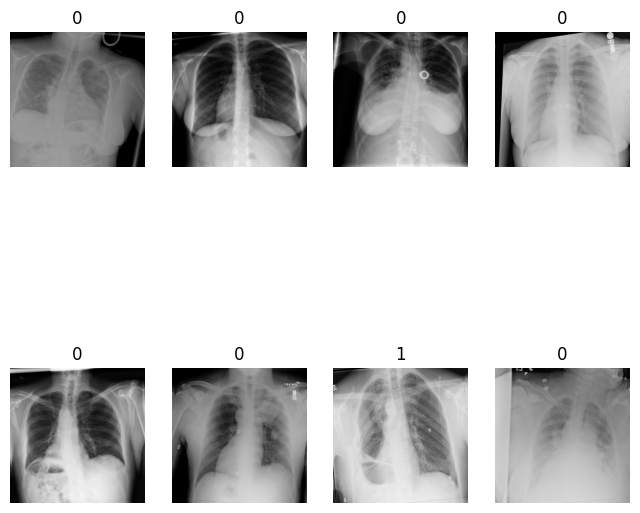

In [ ]:
dls.show_batch(max_n=9, figsize=(8,8))

### TODO:

* Usar FocalLoss
* Entrenar con 1024x1024

In [ ]:
def F1Score(preds, targs):
    preds = torch.argmax(preds, dim=1)
    return f1_score(targs.cpu(), preds.cpu())

def Recall(preds, targs):
    preds = torch.argmax(preds, dim=1)
    return recall_score(targs.cpu(), preds.cpu())

metrics=[accuracy, Recall, F1Score]

In [ ]:
pos_train_num = len(pos_train_aug)
neg_train_num = len(neg_train)
total_train_num = pos_train_num + neg_train_num

w_pos = total_train_num / (2 * pos_train_num)
w_neg = total_train_num / (2 * neg_train_num)

# En orden: [clase 0 (negativa), clase 1 (positiva)]
weights = [w_neg, w_pos]
print(weights)

[0.7867691380349608, 1.3717813977929585]


In [ ]:
weights = torch.tensor(weights, device=default_device())
loss_func = CrossEntropyLossFlat(weight=weights)

In [ ]:
from timm import create_model

In [ ]:
learn = vision_learner(
    dls,
    # arch=models.resnet50,
    arch='efficientnet_b3',
    # arch=models.vgg19_bn,
    # arch=models.densenet121,
    metrics=metrics,
    loss_func=loss_func
).to_fp16()  # Usa half precision si tienes GPU

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [ ]:
learn.freeze()
learn.fit_one_cycle(1)

/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,Recall,F1Score,time
0,0.529520,0.475427,0.776685,0.606367,0.506872,25:56


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: U

In [ ]:
learn.export('./modelo_efficientnet_head.pkl')

In [ ]:
learn = load_learner('./modelo_efficientnet_head.pkl')

In [ ]:
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback

learn.remove_cb(SaveModelCallback)
learn.remove_cb(EarlyStoppingCallback)
learn.dls = dls
learn.metrics = metrics
learn.loss_func = loss_func

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(
    3,  # máximo de épocas
    cbs=[
        EarlyStoppingCallback(
            monitor='F1Score',  # o 'valid_loss', según tu prioridad
            comp=np.greater,     # np.less si usas 'valid_loss'
            patience=4           # cuántas épocas esperar antes de detener
        ),
        SaveModelCallback(monitor='F1Score', comp=np.greater, fname='best_model')
    ],
    lr_max=slice(1e-6, 1e-5)
)

/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,Recall,F1Score,time
0,0.542153,0.480990,0.775749,0.684519,0.546760,08:22
1,0.523124,0.464071,0.790730,0.655680,0.541909,08:19
2,0.513709,0.495747,0.760300,0.714732,0.532089,08:23


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: U

Better model found at epoch 0 with F1Score value: 0.5467600023779801.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: U

In [ ]:
learn.export('./modelo_efficientnet_3epochs.pkl')

In [ ]:
learn = load_learner('./modelo_efficientnet_3epochs.pkl')

In [ ]:
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback

learn.remove_cb(SaveModelCallback)
learn.remove_cb(EarlyStoppingCallback)
learn.dls = dls
learn.metrics = metrics
learn.loss_func = loss_func

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(
    3,  # máximo de épocas
    cbs=[
        EarlyStoppingCallback(
            monitor='F1Score',  # o 'valid_loss', según tu prioridad
            comp=np.greater,     # np.less si usas 'valid_loss'
            patience=4           # cuántas épocas esperar antes de detener
        ),
        SaveModelCallback(monitor='F1Score', comp=np.greater, fname='best_model')
    ],
    lr_max=slice(1e-6, 1e-5)
)

/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,Recall,F1Score,time
0,0.532817,0.488901,0.762640,0.702622,0.534750,08:17
1,0.496601,0.477824,0.774813,0.691511,0.541765,08:15
2,0.522885,0.480370,0.774813,0.700375,0.543614,08:20


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: U

Better model found at epoch 0 with F1Score value: 0.5347495825023916.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: U

Better model found at epoch 1 with F1Score value: 0.5417648518772117.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: U

Better model found at epoch 2 with F1Score value: 0.5436137312541812.


In [ ]:
learn.export('./modelo_efficientnet_6epochs.pkl')

In [ ]:
learn = load_learner('./modelo_efficientnet_6epochs.pkl')

In [ ]:
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback

learn.remove_cb(SaveModelCallback)
learn.remove_cb(EarlyStoppingCallback)
learn.dls = dls
learn.metrics = metrics
learn.loss_func = loss_func

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(
    6,  # máximo de épocas
    cbs=[
        EarlyStoppingCallback(
            monitor='F1Score',  # o 'valid_loss', según tu prioridad
            comp=np.greater,     # np.less si usas 'valid_loss'
            patience=4           # cuántas épocas esperar antes de detener
        ),
        SaveModelCallback(monitor='F1Score', comp=np.greater, fname='best_model')
    ],
    lr_max=slice(1e-6, 1e-5)
)

epoch,train_loss,valid_loss,accuracy,Recall,F1Score,time
0,0.484288,0.472103,0.779026,0.671973,0.530070,41:51
1,0.534821,0.480881,0.771536,0.705680,0.543148,11:21
2,0.496809,0.451477,0.797753,0.661049,0.544516,11:23
3,0.490184,0.438328,0.810393,0.606305,0.527897,11:24
4,0.464226,0.464125,0.783708,0.657303,0.530845,11:21
5,0.476818,0.465413,0.788858,0.697253,0.551932,11:23


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

Better model found at epoch 0 with F1Score value: 0.5300695559122528.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

Better model found at epoch 1 with F1Score value: 0.5431484453956369.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

Better model found at epoch 2 with F1Score value: 0.5445157838416267.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

Better model found at epoch 5 with F1Score value: 0.5519321086736823.


In [ ]:
learn.export('./modelo_efficientnet_12epochs.pkl')

In [ ]:
learn = load_learner('./modelo_efficientnet_12epochs.pkl')

/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback

learn.remove_cb(SaveModelCallback)
learn.remove_cb(EarlyStoppingCallback)
learn.dls = dls
learn.metrics = metrics
learn.loss_func = loss_func

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(
    6,  # máximo de épocas
    cbs=[
        EarlyStoppingCallback(
            monitor='F1Score',  # o 'valid_loss', según tu prioridad
            comp=np.greater,     # np.less si usas 'valid_loss'
            patience=4           # cuántas épocas esperar antes de detener
        ),
        SaveModelCallback(monitor='F1Score', comp=np.greater, fname='best_model')
    ],
    lr_max=slice(1e-6, 1e-5)
)

epoch,train_loss,valid_loss,accuracy,Recall,F1Score,time
0,0.499540,0.436602,0.808521,0.610237,0.522647,15:54
1,0.481549,0.450688,0.798689,0.642509,0.531581,11:03
2,0.471829,0.444167,0.806648,0.648502,0.538788,11:04
3,0.499245,0.457392,0.786985,0.691199,0.540877,11:03
4,0.450234,0.425451,0.817884,0.622722,0.541562,11:00
5,0.473726,0.435824,0.806648,0.650936,0.542614,10:59


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: U

Better model found at epoch 0 with F1Score value: 0.5226470159054434.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: U

Better model found at epoch 1 with F1Score value: 0.5315806540525645.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: U

Better model found at epoch 2 with F1Score value: 0.5387875545178922.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: U

Better model found at epoch 3 with F1Score value: 0.5408772043603508.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: U

Better model found at epoch 4 with F1Score value: 0.541562494933282.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: U

Better model found at epoch 5 with F1Score value: 0.5426144808167283.


In [ ]:
learn.export('./modelo_efficientnet_18epochs.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScal

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScal

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.94      0.82      0.88      1660
           1       0.57      0.83      0.67       476

    accuracy                           0.82      2136
   macro avg       0.75      0.82      0.77      2136
weighted avg       0.86      0.82      0.83      2136



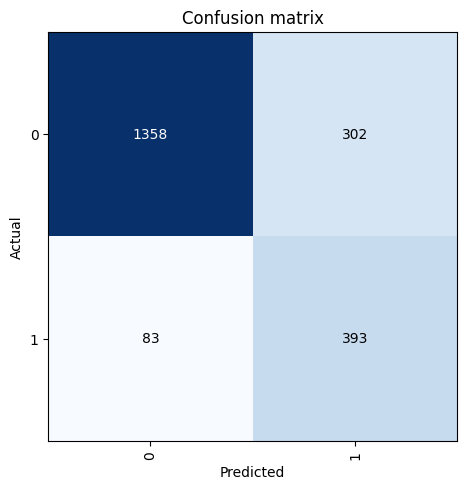

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()